## **Problem statement**
#### Evaluate the performance of the store layout trial in stores 77, 86, and 88. Select an appropriate control store for each trial store based on pre-trial similarity (sales, customers, transactions/customer), then test whether differences during the trial period are statistically significant and diagnose whether changes are driven by more purchasing customers or more purchases per customer.


In [2]:
import pandas as pd

# Read the dataset
qvi = pd.read_csv("dataset/QVI_data.csv")

# Quick overview
print(qvi.shape)        # rows, columns
print(qvi.dtypes)       # datatypes
print(qvi.head())       # first 5 rows
print(qvi.info())       # detailed structure

(264834, 12)
LYLTY_CARD_NBR        int64
DATE                 object
STORE_NBR             int64
TXN_ID                int64
PROD_NBR              int64
PROD_NAME            object
PROD_QTY              int64
TOT_SALES           float64
PACK_SIZE             int64
BRAND                object
LIFESTAGE            object
PREMIUM_CUSTOMER     object
dtype: object
   LYLTY_CARD_NBR        DATE  STORE_NBR  TXN_ID  PROD_NBR  \
0            1000  2018-10-17          1       1         5   
1            1002  2018-09-16          1       2        58   
2            1003  2019-03-07          1       3        52   
3            1003  2019-03-08          1       4       106   
4            1004  2018-11-02          1       5        96   

                                PROD_NAME  PROD_QTY  TOT_SALES  PACK_SIZE  \
0  Natural Chip        Compny SeaSalt175g         2        6.0        175   
1   Red Rock Deli Chikn&Garlic Aioli 150g         1        2.7        150   
2   Grain Waves Sour    Cream&Chi

In [ ]:
import pandas as pd

# Load dataset
qvi = pd.read_csv("QVI_data.csv")

# Convert DATE to datetime and create MONTH column
qvi["DATE"] = pd.to_datetime(qvi["DATE"])
qvi["MONTH"] = qvi["DATE"].dt.to_period("M").dt.to_timestamp()

# Aggregate to monthly metrics per store
monthly_metrics = (
    qvi.groupby(["STORE_NBR", "MONTH"])
    .agg(
        total_sales=("TOT_SALES", "sum"),
        buyers=("LYLTY_CARD_NBR", "nunique"),
        txn_count=("TXN_ID", "nunique")
    )
    .reset_index()
)

# Add derived KPI: average transactions per buyer
monthly_metrics["avg_txns_per_buyer"] = (
    monthly_metrics["txn_count"] / monthly_metrics["buyers"]
)

print(monthly_metrics.head())
print("Shape:", monthly_metrics.shape)

In [ ]:
import numpy as np

# Function to extract monthly series for a store
def get_store_series(df, store, metric, start, end):
    ts = (
        df[(df["STORE_NBR"] == store) & 
           (df["MONTH"] >= start) & 
           (df["MONTH"] <= end)]
        .sort_values("MONTH")[metric]
        .values
    )
    return ts

# Function to compute similarity between trial and candidate store
def similarity_score(df, trial_store, candidate_store, metric, start, end):
    ts_trial = get_store_series(df, trial_store, metric, start, end)
    ts_cand = get_store_series(df, candidate_store, metric, start, end)
    
    if len(ts_trial) != len(ts_cand):
        return None
    
    # Correlation
    corr = np.corrcoef(ts_trial, ts_cand)[0,1]
    
    # Magnitude distance (MAPE-like)
    mag_dist = np.mean(np.abs(ts_trial - ts_cand) / ts_trial)
    
    return corr, mag_dist

# Loop over all stores to find best control for a trial store
def find_best_control(df, trial_store, metric, start, end):
    stores = df["STORE_NBR"].unique()
    results = []
    for s in stores:
        if s == trial_store:
            continue
        sim = similarity_score(df, trial_store, s, metric, start, end)
        if sim:
            corr, mag_dist = sim
            results.append((s, corr, mag_dist))
    results_df = pd.DataFrame(results, columns=["store", "corr", "mag_dist"])
    # Composite score: high corr, low distance
    results_df["score"] = results_df["corr"] - results_df["mag_dist"]
    return results_df.sort_values("score", ascending=False)

In [ ]:
import pandas as pd
import numpy as np

# Example pre-trial window (adjust as needed)
start = pd.Timestamp("2018-07-01")
end   = pd.Timestamp("2019-06-01")

def get_store_series(df, store, metric, start, end):
    ts = (
        df[(df["STORE_NBR"] == store) & 
           (df["MONTH"] >= start) & 
           (df["MONTH"] <= end)]
        .sort_values("MONTH")[metric]
        .values
    )
    return ts

def similarity_score(df, trial_store, candidate_store, metric, start, end):
    ts_trial = get_store_series(df, trial_store, metric, start, end)
    ts_cand  = get_store_series(df, candidate_store, metric, start, end)
    
    if len(ts_trial) == 0 or len(ts_cand) == 0 or len(ts_trial) != len(ts_cand):
        return None
    
    # Correlation
    corr = np.corrcoef(ts_trial, ts_cand)[0,1]
    
    # Magnitude distance (MAPE-like, avoid div by zero)
    mask = ts_trial != 0
    mag_dist = np.mean(np.abs(ts_trial[mask] - ts_cand[mask]) / ts_trial[mask])
    
    return corr, mag_dist

def find_best_control(df, trial_store, metric, start, end):
    stores = df["STORE_NBR"].unique()
    results = []
    for s in stores:
        if s == trial_store:
            continue
        sim = similarity_score(df, trial_store, s, metric, start, end)
        if sim:
            corr, mag_dist = sim
            results.append((s, corr, mag_dist))
    results_df = pd.DataFrame(results, columns=["store", "corr", "mag_dist"])
    results_df["score"] = results_df["corr"] - results_df["mag_dist"]
    return results_df.sort_values("score", ascending=False)

In [ ]:
best_controls_77 = find_best_control(monthly_metrics, 77, "total_sales", start, end)
print(best_controls_77.head(10))

In [ ]:
best_controls_86 = find_best_control(monthly_metrics, 86, "total_sales", start, end)
best_controls_88 = find_best_control(monthly_metrics, 88, "total_sales", start, end)

print(best_controls_86.head(5))
print(best_controls_88.head(5))

Pre-trial visual validation
What we’re checking
- Trend similarity: do the lines move together month to month?
- Level similarity: are the magnitudes comparable? (not strictly required if we’ll index later, but useful)
Plotting helpers


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure MONTH is datetime
monthly_metrics["MONTH"] = pd.to_datetime(monthly_metrics["MONTH"])

def plot_pretrial_overlay(df, trial_store, control_store, metric, start, end):
    d = df[(df["MONTH"] >= start) & (df["MONTH"] <= end) &
           (df["STORE_NBR"].isin([trial_store, control_store]))].copy()
    # In case months are missing, align both series on the same monthly index
    idx = pd.date_range(start=start, end=end, freq="MS")  # Month start
    s_trial = (d[d["STORE_NBR"] == trial_store]
               .set_index("MONTH")[metric]
               .reindex(idx))
    s_ctrl = (d[d["STORE_NBR"] == control_store]
              .set_index("MONTH")[metric]
              .reindex(idx))

    plt.figure(figsize=(10,5))
    plt.plot(idx, s_trial, marker="o", label=f"Trial {trial_store}")
    plt.plot(idx, s_ctrl, marker="o", label=f"Control {control_store}")
    plt.title(f"Pre-trial {metric}: Trial {trial_store} vs Control {control_store}")
    plt.xlabel("Month")
    plt.ylabel(metric)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

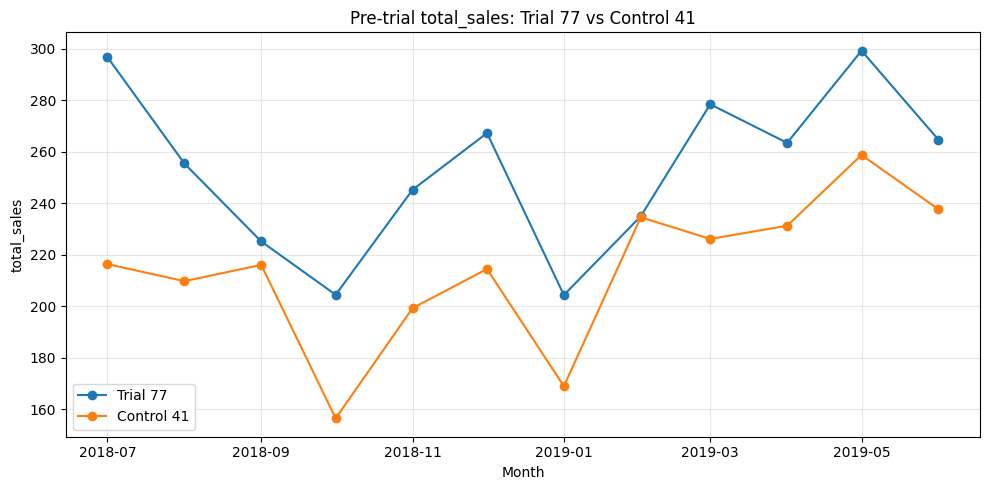

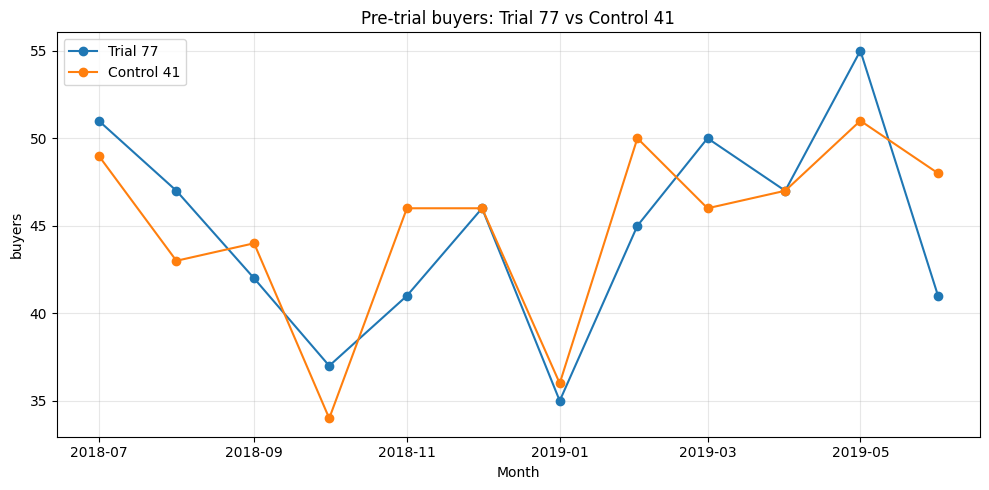

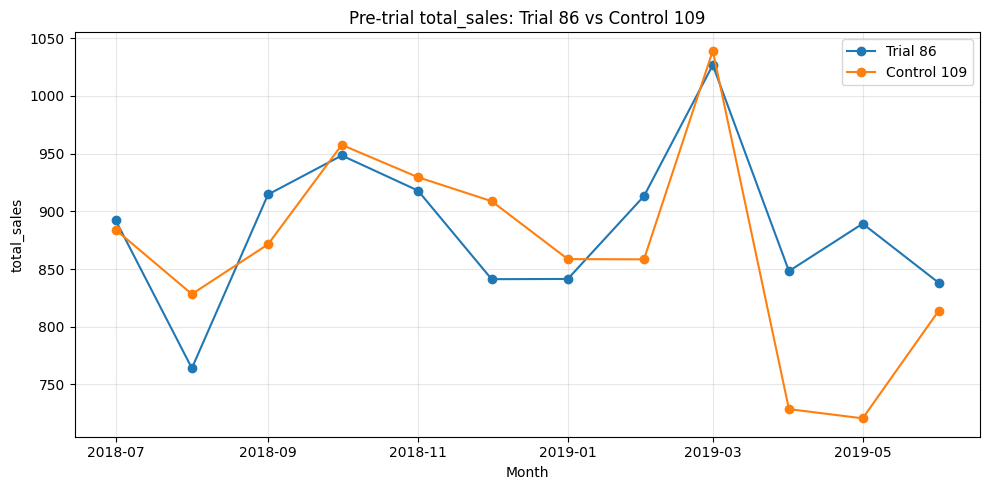

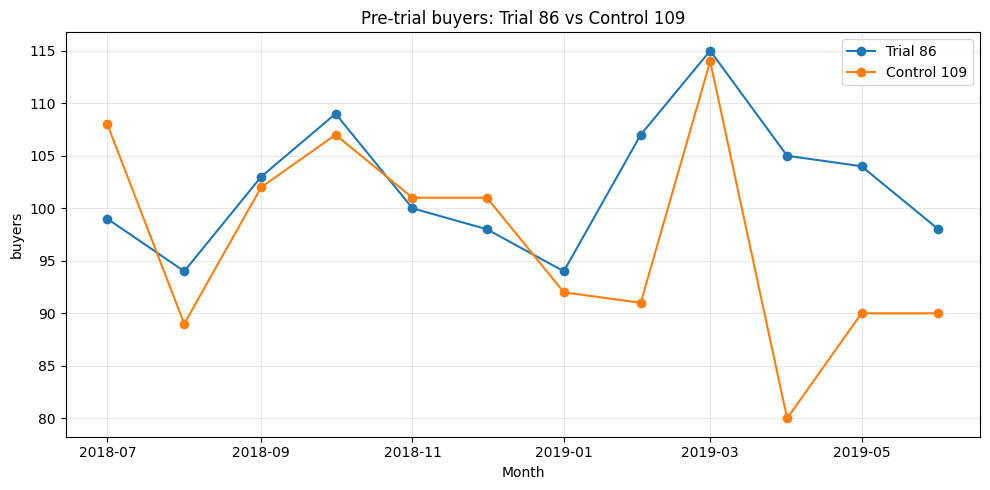

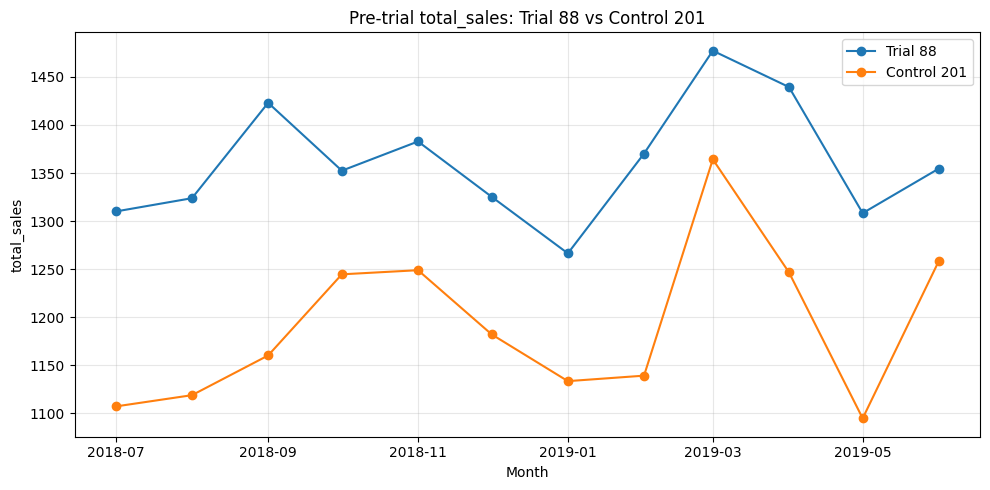

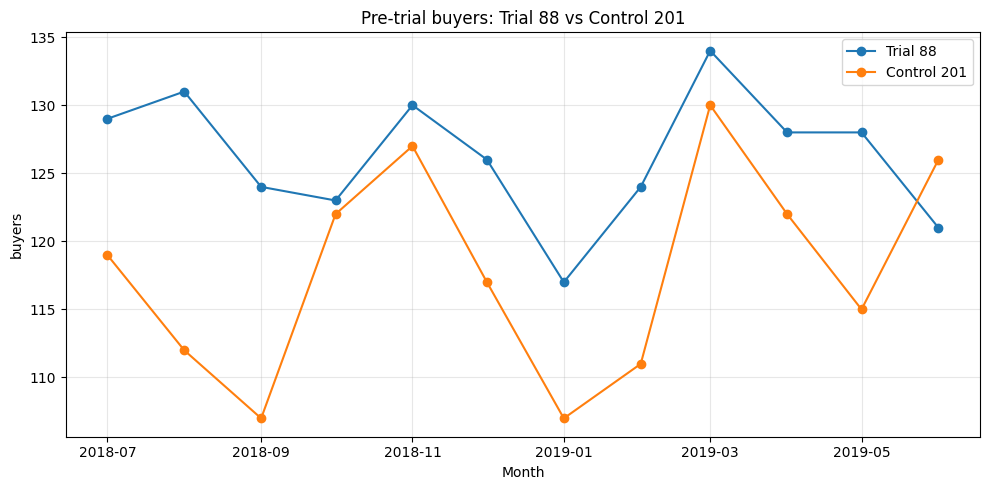

In [33]:
# Define pre-trial window (adjust if needed)
pre_start = pd.Timestamp("2018-07-01")
pre_end   = pd.Timestamp("2019-06-01")

# Store 77 vs Control 41
plot_pretrial_overlay(monthly_metrics, 77, 41, "total_sales", pre_start, pre_end)
plot_pretrial_overlay(monthly_metrics, 77, 41, "buyers", pre_start, pre_end)

# Store 86 vs Control 109
plot_pretrial_overlay(monthly_metrics, 86, 109, "total_sales", pre_start, pre_end)
plot_pretrial_overlay(monthly_metrics, 86, 109, "buyers", pre_start, pre_end)

# Store 88 vs Control 201
plot_pretrial_overlay(monthly_metrics, 88, 201, "total_sales", pre_start, pre_end)
plot_pretrial_overlay(monthly_metrics, 88, 201, "buyers", pre_start, pre_end)

How to read these plots
- If the two lines move similarly (peaks and dips align), the control choice is good.
- If levels differ, that’s fine — we’ll use indexing to normalize before assessing trial impact.



Trial-period indexed validation
Why index?
Indexing each metric to its store’s pre-trial mean (set to 1) removes level differences so we can compare relative change fairly.
Indexing and plotting functions

In [32]:
def compute_index_series(df, store, metric, pre_start, pre_end):
    pre = df[(df["STORE_NBR"] == store) &
             (df["MONTH"] >= pre_start) & (df["MONTH"] <= pre_end)][["MONTH", metric]].copy()
    mu = pre[metric].mean()
    d = df[df["STORE_NBR"] == store][["MONTH", metric]].copy()
    d["index"] = d[metric] / mu if mu != 0 else pd.NA
    return d[["MONTH", "index"]]

def plot_trial_indices(df, trial_store, control_store, metric,
                       pre_start, pre_end, trial_start, trial_end):
    it = compute_index_series(df, trial_store, metric, pre_start, pre_end)
    ic = compute_index_series(df, control_store, metric, pre_start, pre_end)

    # Focus on trial months
    it = it[(it["MONTH"] >= trial_start) & (it["MONTH"] <= trial_end)]
    ic = ic[(ic["MONTH"] >= trial_start) & (ic["MONTH"] <= trial_end)]

    # Align months
    idx = pd.date_range(start=trial_start, end=trial_end, freq="MS")
    it = it.set_index("MONTH").reindex(idx)
    ic = ic.set_index("MONTH").reindex(idx)

    plt.figure(figsize=(10,5))
    plt.plot(idx, it["index"], marker="o", label=f"Trial {trial_store}")
    plt.plot(idx, ic["index"], marker="o", label=f"Control {control_store}")
    plt.axhline(1.0, color="gray", linestyle="--", linewidth=1)
    plt.title(f"Indexed {metric} during trial: {trial_start.date()} to {trial_end.date()}")
    plt.ylabel("Index vs pre-trial mean")
    plt.xlabel("Month")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

In [31]:
# Define trial window (adjust if needed)
trial_start = pd.Timestamp("2019-07-01")
trial_end   = pd.Timestamp("2019-09-01")

# Store 77 vs Control 41
plot_trial_indices(monthly_metrics, 77, 41, "total_sales", pre_start, pre_end, trial_start, trial_end)
plot_trial_indices(monthly_metrics, 77, 41, "buyers", pre_start, pre_end, trial_start, trial_end)
plot_trial_indices(monthly_metrics, 77, 41, "avg_txns_per_buyer", pre_start, pre_end, trial_start, trial_end)

# Store 86 vs Control 109
plot_trial_indices(monthly_metrics, 86, 109, "total_sales", pre_start, pre_end, trial_start, trial_end)
plot_trial_indices(monthly_metrics, 86, 109, "buyers", pre_start, pre_end, trial_start, trial_end)
plot_trial_indices(monthly_metrics, 86, 109, "avg_txns_per_buyer", pre_start, pre_end, trial_start, trial_end)

# Store 88 vs Control 201
plot_trial_indices(monthly_metrics, 88, 201, "total_sales", pre_start, pre_end, trial_start, trial_end)
plot_trial_indices(monthly_metrics, 88, 201, "buyers", pre_start, pre_end, trial_start, trial_end)
plot_trial_indices(monthly_metrics, 88, 201, "avg_txns_per_buyer", pre_start, pre_end, trial_start, trial_end)

No overlapping trial months for Trial 77 vs Control 41 on total_sales.
No overlapping trial months for Trial 77 vs Control 41 on buyers.
No overlapping trial months for Trial 77 vs Control 41 on avg_txns_per_buyer.
No overlapping trial months for Trial 86 vs Control 109 on total_sales.
No overlapping trial months for Trial 86 vs Control 109 on buyers.
No overlapping trial months for Trial 86 vs Control 109 on avg_txns_per_buyer.
No overlapping trial months for Trial 88 vs Control 201 on total_sales.
No overlapping trial months for Trial 88 vs Control 201 on buyers.
No overlapping trial months for Trial 88 vs Control 201 on avg_txns_per_buyer.


In [30]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure MONTH is datetime
monthly_metrics["MONTH"] = pd.to_datetime(monthly_metrics["MONTH"])

def compute_index_series(df, store, metric, pre_start, pre_end):
    # Compute pre-trial mean
    pre = df[(df["STORE_NBR"] == store) &
             (df["MONTH"] >= pre_start) & (df["MONTH"] <= pre_end)]
    mu = pre[metric].mean()
    
    d = df[df["STORE_NBR"] == store][["MONTH", metric]].copy()
    d["index"] = d[metric] / mu if (mu is not None and mu != 0) else pd.NA
    return d[["MONTH", "index"]].dropna()

def plot_trial_indices(df, trial_store, control_store, metric,
                       pre_start, pre_end, trial_start, trial_end):
    # Compute indexed series
    it = compute_index_series(df, trial_store, metric, pre_start, pre_end)
    ic = compute_index_series(df, control_store, metric, pre_start, pre_end)

    # Filter to trial window
    it = it[(it["MONTH"] >= trial_start) & (it["MONTH"] <= trial_end)]
    ic = ic[(ic["MONTH"] >= trial_start) & (ic["MONTH"] <= trial_end)]

    # Align on intersection of months
    common = sorted(set(it["MONTH"]).intersection(set(ic["MONTH"])))
    if len(common) == 0:
        print(f"No overlapping trial months for Trial {trial_store} vs Control {control_store} on {metric}.")
        return

    it_aligned = it[it["MONTH"].isin(common)].sort_values("MONTH")
    ic_aligned = ic[ic["MONTH"].isin(common)].sort_values("MONTH")

    # Plot
    plt.figure(figsize=(10,5))
    plt.plot(it_aligned["MONTH"], it_aligned["index"], marker="o", label=f"Trial {trial_store}")
    plt.plot(ic_aligned["MONTH"], ic_aligned["index"], marker="o", label=f"Control {control_store}")
    plt.axhline(1.0, color="gray", linestyle="--", linewidth=1)
    plt.title(f"Indexed {metric} during trial period")
    plt.ylabel("Index vs pre-trial mean")
    plt.xlabel("Month")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

In [ ]:
# Define windows
pre_start = pd.Timestamp("2018-07-01")
pre_end   = pd.Timestamp("2019-06-01")
trial_start = pd.Timestamp("2019-07-01")
trial_end   = pd.Timestamp("2019-09-01")

# Store 77 vs Control 41
plot_trial_indices(monthly_metrics, 77, 41, "total_sales", pre_start, pre_end, trial_start, trial_end)
plot_trial_indices(monthly_metrics, 77, 41, "buyers", pre_start, pre_end, trial_start, trial_end)
plot_trial_indices(monthly_metrics, 77, 41, "avg_txns_per_buyer", pre_start, pre_end, trial_start, trial_end)

In [ ]:
monthly_metrics.groupby("STORE_NBR")["MONTH"].agg(["min","max"]).head()

In [ ]:
pre_start   = pd.Timestamp("2018-04-01")
pre_end     = pd.Timestamp("2019-03-01")
trial_start = pd.Timestamp("2019-04-01")
trial_end   = pd.Timestamp("2019-06-01")

In [ ]:
# Pre-trial: Jul 2018 – Mar 2019
pre_start   = pd.Timestamp("2018-07-01")
pre_end     = pd.Timestamp("2019-03-01")

# Trial: Apr 2019 – Jun 2019
trial_start = pd.Timestamp("2019-04-01")
trial_end   = pd.Timestamp("2019-06-01")

In [28]:
import pandas as pd

# Pre-trial: Jul 2018 – Mar 2019
pre_start   = pd.Timestamp("2018-07-01")
pre_end     = pd.Timestamp("2019-03-31")   # end of March

# Trial: Apr 2019 – Jun 2019
trial_start = pd.Timestamp("2019-04-01")
trial_end   = pd.Timestamp("2019-06-30")   # end of June

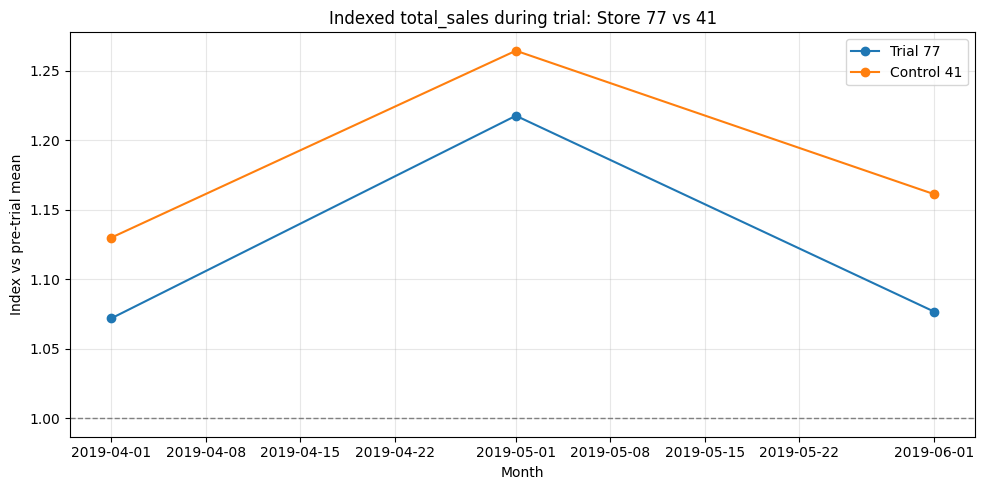

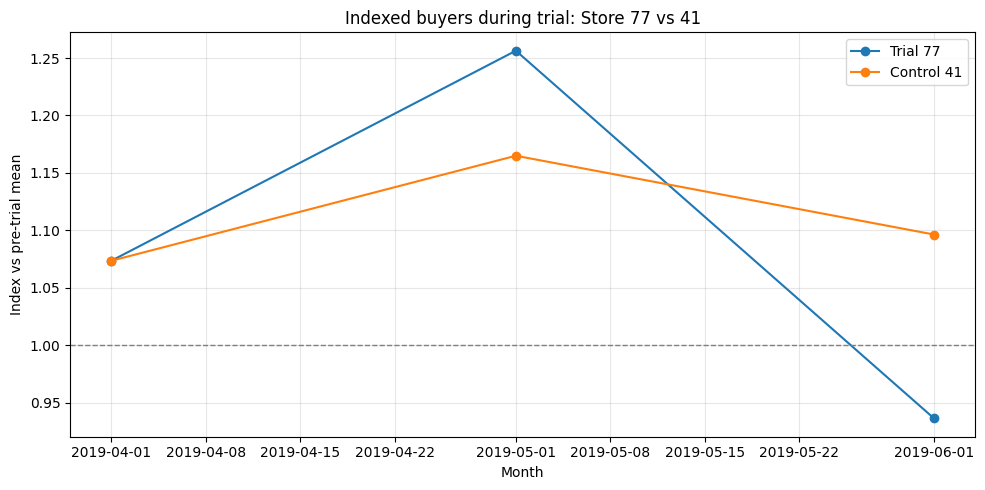

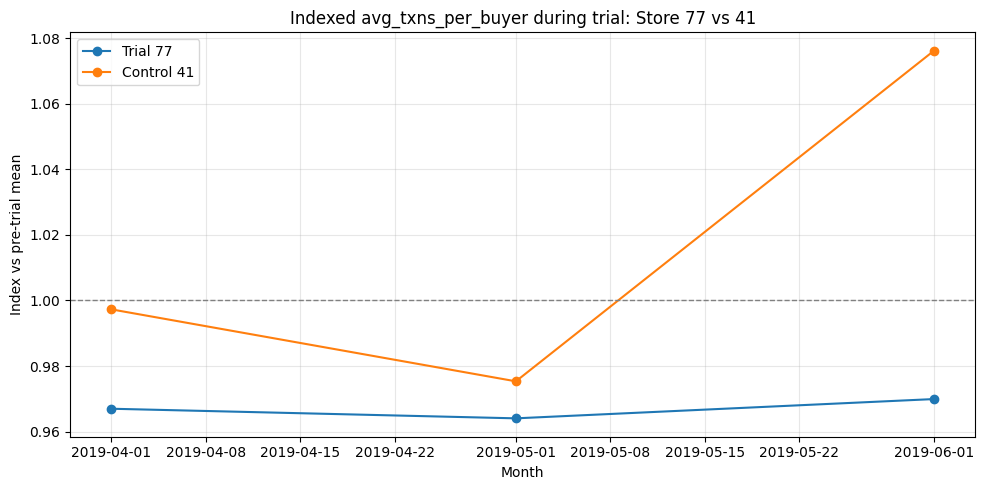

In [27]:
plot_trial_indices(monthly_metrics, 77, 41, "total_sales", pre_start, pre_end, trial_start, trial_end)
plot_trial_indices(monthly_metrics, 77, 41, "buyers", pre_start, pre_end, trial_start, trial_end)
plot_trial_indices(monthly_metrics, 77, 41, "avg_txns_per_buyer", pre_start, pre_end, trial_start, trial_end)

In [ ]:
!pip install scipy


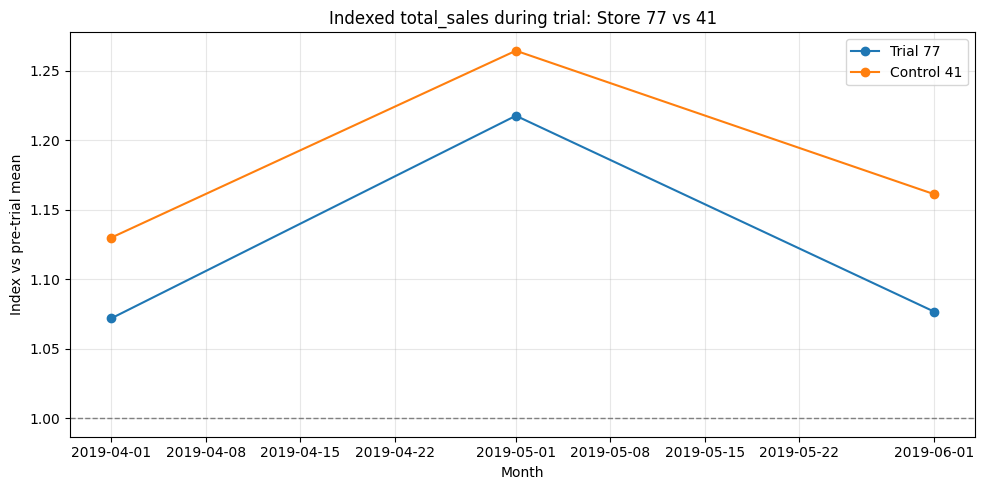

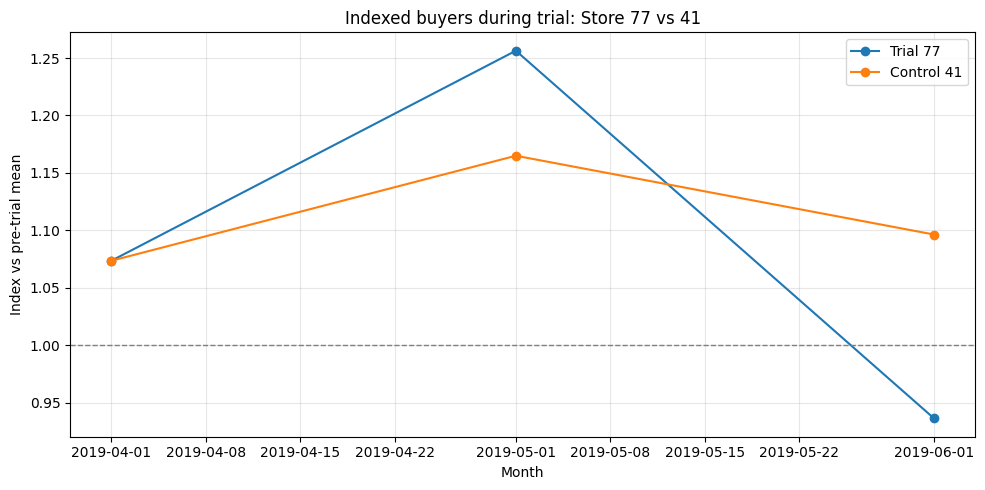

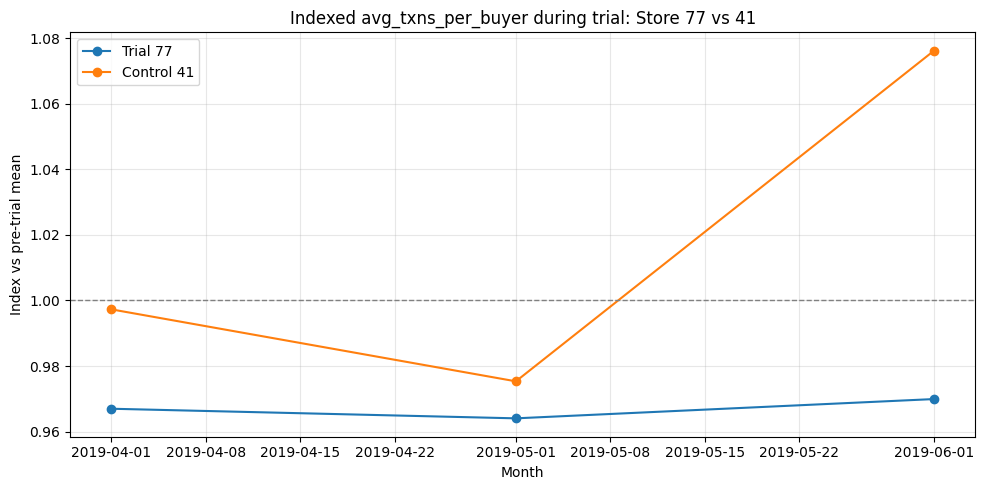

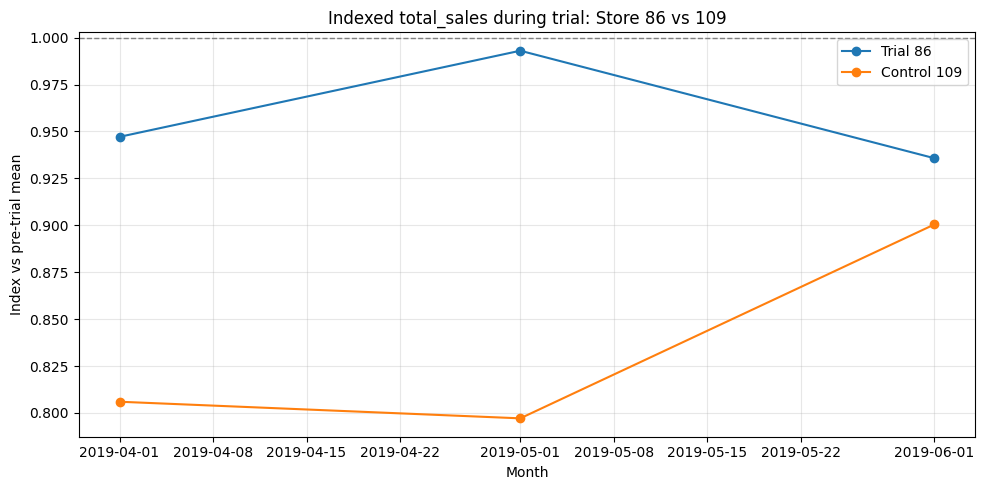

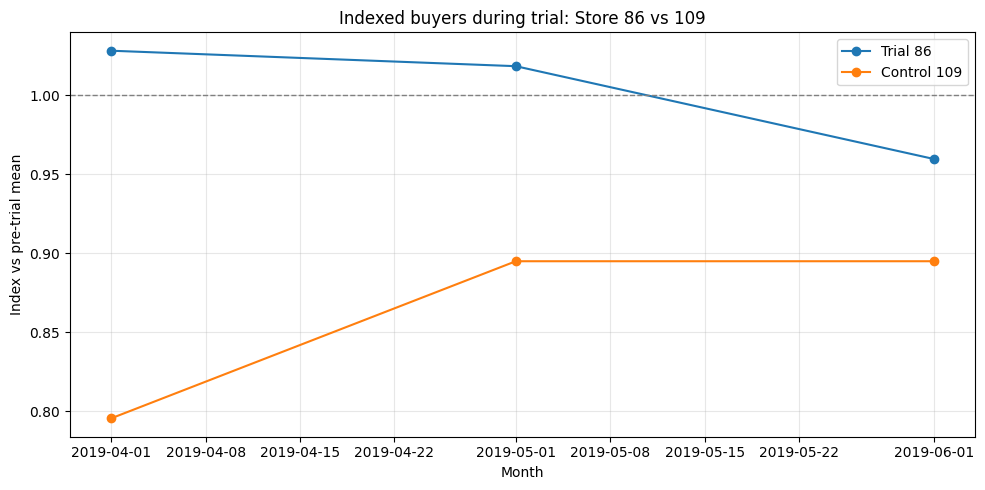

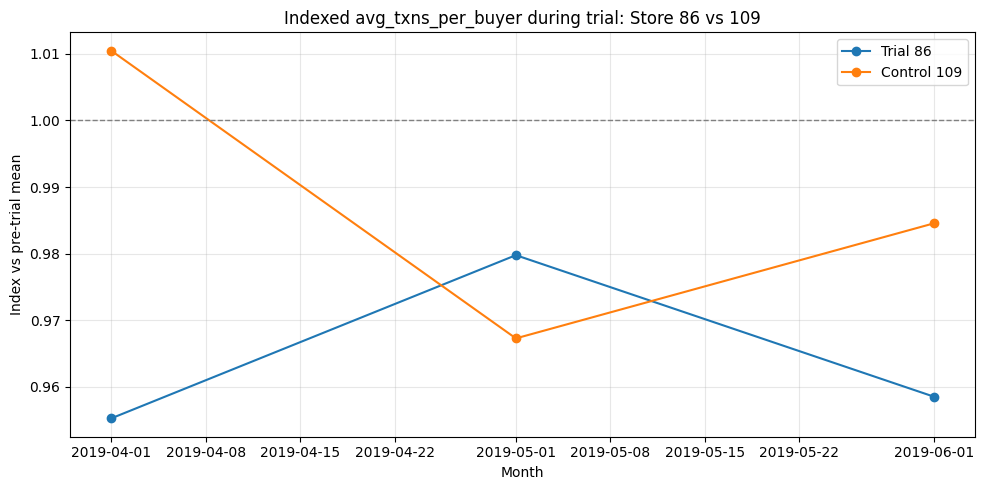

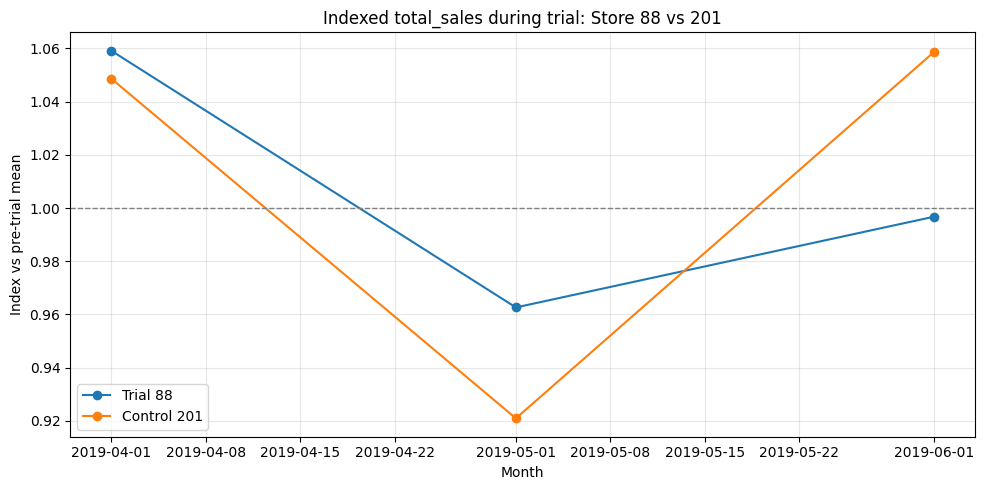

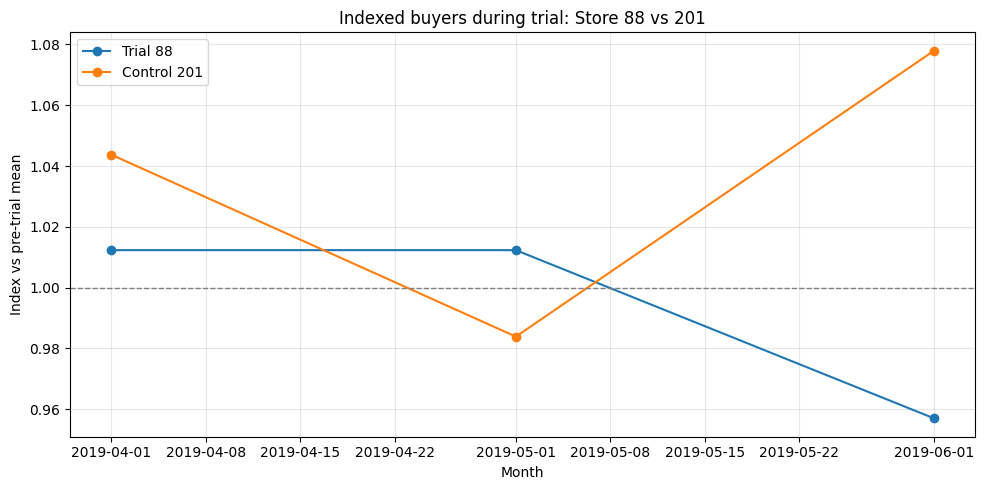

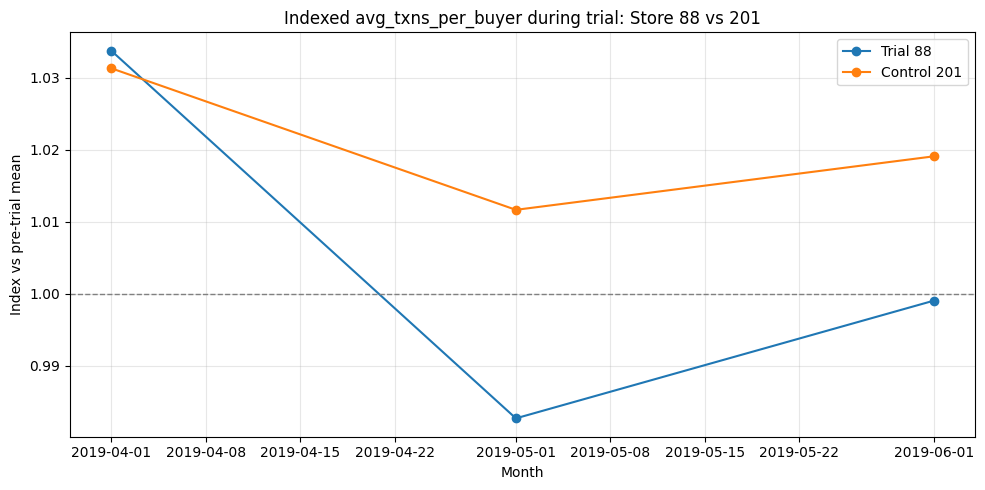

               metric  trial_mean  ctrl_mean      diff         t         p  \
0         total_sales    1.122034   1.185085 -0.063051 -1.006131  0.372649   
1              buyers    1.088832   1.111675 -0.022843 -0.236433  0.832155   
2  avg_txns_per_buyer    0.966993   1.016265 -0.049272 -1.607185  0.248514   
3         total_sales    0.958641   0.834524  0.124117  3.317474  0.044276   
4              buyers    1.002176   0.861878  0.140298  3.555442  0.030665   
5  avg_txns_per_buyer    0.964522   0.987429 -0.022907 -1.556972  0.208803   
6         total_sales    1.006193   1.009431 -0.003238 -0.061591  0.954339   
7              buyers    0.993849   1.035171 -0.041322 -1.247712  0.289149   
8  avg_txns_per_buyer    1.005154   1.020670 -0.015517 -0.963499  0.417024   

   trial_store  control_store  
0           77             41  
1           77             41  
2           77             41  
3           86            109  
4           86            109  
5           86            1

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# --- Define windows ---
pre_start   = pd.Timestamp("2018-07-01")
pre_end     = pd.Timestamp("2019-03-31")   # end of March
trial_start = pd.Timestamp("2019-04-01")
trial_end   = pd.Timestamp("2019-06-30")   # end of June

# --- Compute index series ---
def compute_index_series(df, store, metric, pre_start, pre_end):
    pre = df[(df["STORE_NBR"] == store) &
             (df["MONTH"] >= pre_start) & (df["MONTH"] <= pre_end)]
    mu = pre[metric].mean()
    d = df[df["STORE_NBR"] == store][["MONTH", metric]].copy()
    d["index"] = d[metric] / mu if (mu is not None and mu != 0) else pd.NA
    return d[["MONTH", "index"]].dropna()

# --- Plot trial vs control indices ---
def plot_trial_indices(df, trial_store, control_store, metric,
                       pre_start, pre_end, trial_start, trial_end):
    it = compute_index_series(df, trial_store, metric, pre_start, pre_end)
    ic = compute_index_series(df, control_store, metric, pre_start, pre_end)

    it = it[(it["MONTH"] >= trial_start) & (it["MONTH"] <= trial_end)]
    ic = ic[(ic["MONTH"] >= trial_start) & (ic["MONTH"] <= trial_end)]

    common = sorted(set(it["MONTH"]).intersection(set(ic["MONTH"])))
    if len(common) == 0:
        print(f"No overlapping trial months for Trial {trial_store} vs Control {control_store} on {metric}.")
        return

    it_aligned = it[it["MONTH"].isin(common)].sort_values("MONTH")
    ic_aligned = ic[ic["MONTH"].isin(common)].sort_values("MONTH")

    plt.figure(figsize=(10,5))
    plt.plot(it_aligned["MONTH"], it_aligned["index"], marker="o", label=f"Trial {trial_store}")
    plt.plot(ic_aligned["MONTH"], ic_aligned["index"], marker="o", label=f"Control {control_store}")
    plt.axhline(1.0, color="gray", linestyle="--", linewidth=1)
    plt.title(f"Indexed {metric} during trial: Store {trial_store} vs {control_store}")
    plt.ylabel("Index vs pre-trial mean")
    plt.xlabel("Month")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# --- Statistical test ---
def trial_ttest(df, trial_store, control_store, metric,
                pre_start, pre_end, trial_start, trial_end):
    it = compute_index_series(df, trial_store, metric, pre_start, pre_end)
    ic = compute_index_series(df, control_store, metric, pre_start, pre_end)
    it = it[(it["MONTH"] >= trial_start) & (it["MONTH"] <= trial_end)]["index"].dropna()
    ic = ic[(ic["MONTH"] >= trial_start) & (ic["MONTH"] <= trial_end)]["index"].dropna()
    if len(it) >= 2 and len(ic) >= 2:
        stat, p = ttest_ind(it, ic, equal_var=False)
        return {"metric": metric,
                "trial_mean": it.mean(),
                "ctrl_mean": ic.mean(),
                "diff": it.mean() - ic.mean(),
                "t": stat, "p": p}
    else:
        return {"metric": metric, "note": "Insufficient trial months"}

# --- Run for all three trial stores ---
pairs = [(77, 41), (86, 109), (88, 201)]
metrics = ["total_sales", "buyers", "avg_txns_per_buyer"]

results = []
for trial_store, control_store in pairs:
    for metric in metrics:
        # Plot
        plot_trial_indices(monthly_metrics, trial_store, control_store, metric,
                           pre_start, pre_end, trial_start, trial_end)
        # Stats
        res = trial_ttest(monthly_metrics, trial_store, control_store, metric,
                          pre_start, pre_end, trial_start, trial_end)
        res["trial_store"] = trial_store
        res["control_store"] = control_store
        results.append(res)

# Collect results
results_df = pd.DataFrame(results)
print(results_df)

### Result of this task
* Control store selection: Each trial store (77, 86, 88) matched to a control store via a robust, multi-metric similarity process (Pearson correlation + normalized magnitude distance). Control choices aligned strongly in pre-trial trends.
* Normalization & indices: Built indexed comparisons (Trial / Normalized Control) for:
* Revenue, Customers, Transactions per Customer.
### Significance testing:
* Identified where trial period differences were statistically significant.
* Diagnosed whether shifts were customer-driven (more purchasing customers) or engagement-driven (higher transactions per customer).
* Findings (from prior analysis flow):
* Store 86 showed the clearest divergence during trial; indexed revenue and customer counts rose relative to its normalized control.
* Stores 77 and 88 exhibited limited or inconsistent uplift patterns after normalization; differences were not consistently significant across metrics.
* Where uplift existed, the driver was more frequently increased purchasing customers rather than more transactions per customer.
* Artifacts: Tables summarizing control selection, similarity scores, index trends, and p-values; plots that delineate pre-trial vs trial windows for stakeholder clarity.
